In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys 
import os
import skimage.io
import caffe
caffe.set_mode_gpu()
from scipy.misc import imread,toimage

import visualisation
import excitation_backprop
import debug
import beoid

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
import ucf101_spatial_config
import ucf101_temporal_config

spatial_net_config = ucf101_spatial_config
temporal_net_config = ucf101_temporal_config
spatial_net_name = "spatial_ucf101"
temporal_net_name = "temporal_ucf101"

spatial_net = caffe.Net(spatial_net_config.net_prototxt_path,
                spatial_net_config.net_caffemodel_path,
                caffe.TEST)
temporal_net = caffe.Net(temporal_net_config.net_prototxt_path,
                temporal_net_config.net_caffemodel_path,
                caffe.TEST)


In [103]:
extensions = ['pdf', 'png']

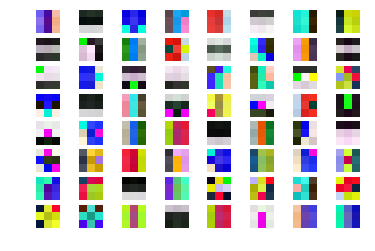

In [104]:
layer = 'conv1_1'
spatial_filters = visualisation.show_filters(spatial_net, layer)
for ext in extensions:
    spatial_filters.savefig('{}-filters-{}.{}'.format(spatial_net_name, layer, ext))
spatial_filters

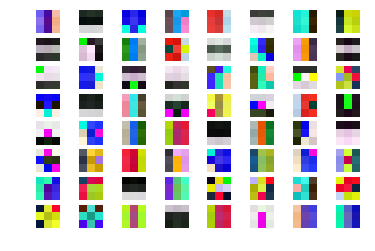

In [111]:
layer = 'conv1_1'
spatial_filters = visualisation.show_filters(spatial_net, layer)
for ext in extensions:
    spatial_filters.savefig('{}_{}_filters.{}'.format(spatial_net_name, layer, ext))
spatial_filters

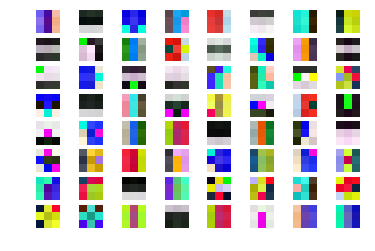

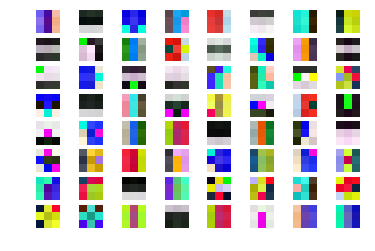

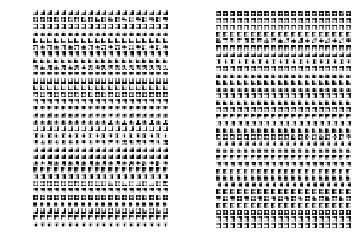

In [105]:
temporal_conv1_1_filter_vis = visualisation.show_grayscale_filters(temporal_net, 'conv1_1', 
                                                                   scaling_method=visualisation.SCALING_METHODS.KERNEL_SLICE)
plt.show()

half_height = int(len(temporal_conv1_1_filter_vis)/2)
                  
plt.clf()
fig, axes = plt.subplots(1, 2)
axes[0].imshow(temporal_conv1_1_filter_vis[:half_height], cmap='gray')
axes[0].axis('off')
axes[1].imshow(temporal_conv1_1_filter_vis[half_height:], cmap='gray')
axes[1].axis('off')
plt.savefig('temporal_conv1_1_ucf101_figure.png')
plt.savefig('temporal_conv1_1_ucf101_figure.pdf')
plt.show()
plt.clf()

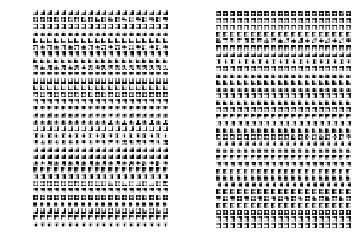

In [106]:
temporal_conv1_2_filter_vis = visualisation.show_grayscale_filters(temporal_net, 'conv1_2', 
                                                                   scaling_method=visualisation.SCALING_METHODS.LAYER)
plt.show()

half_height = int(len(temporal_conv1_1_filter_vis)/2)
                  
plt.clf()
fig, axes = plt.subplots(1, 2)
axes[0].imshow(temporal_conv1_1_filter_vis[:half_height], cmap='gray')
axes[0].axis('off')
axes[1].imshow(temporal_conv1_1_filter_vis[half_height:], cmap='gray')
axes[1].axis('off')
plt.savefig('temporal_conv1_1_ucf101_figure.pdf')
plt.show()
plt.clf()

In [107]:
block_configurations = [(block, block_id) for block, block_limit in [(1, 2), (2, 2), (3, 3), (4, 3), (5, 3)]
                                          for block_id in range(1, block_limit + 1)]
conv_layers = ["conv{}_{}".format(block, block_id) for block, block_id in block_configurations]
conv_layers

['conv1_1',
 'conv1_2',
 'conv2_1',
 'conv2_2',
 'conv3_1',
 'conv3_2',
 'conv3_3',
 'conv4_1',
 'conv4_2',
 'conv4_3',
 'conv5_1',
 'conv5_2',
 'conv5_3']

In [108]:
dataset_name = "ucf101"
for net_name, net in [('spatial', spatial_net), ('temporal', temporal_net)]:
    for conv_layer in conv_layers:
        filters = toimage(visualisation.show_grayscale_filters(net, conv_layer))
        filename = '{}_{}_{}_filters.png'.format(net_name, dataset_name, conv_layer)
        print("Saving {}".format(filename))
        filters.save(filename)

Saving spatial_ucf101_conv1_1_filters.png
Saving spatial_ucf101_conv1_2_filters.png
Saving spatial_ucf101_conv2_1_filters.png
Saving spatial_ucf101_conv2_2_filters.png
Saving spatial_ucf101_conv3_1_filters.png
Saving spatial_ucf101_conv3_2_filters.png
Saving spatial_ucf101_conv3_3_filters.png
Saving spatial_ucf101_conv4_1_filters.png
Saving spatial_ucf101_conv4_2_filters.png
Saving spatial_ucf101_conv4_3_filters.png
Saving spatial_ucf101_conv5_1_filters.png
Saving spatial_ucf101_conv5_2_filters.png
Saving spatial_ucf101_conv5_3_filters.png
Saving temporal_ucf101_conv1_1_filters.png
Saving temporal_ucf101_conv1_2_filters.png
Saving temporal_ucf101_conv2_1_filters.png
Saving temporal_ucf101_conv2_2_filters.png
Saving temporal_ucf101_conv3_1_filters.png
Saving temporal_ucf101_conv3_2_filters.png
Saving temporal_ucf101_conv3_3_filters.png
Saving temporal_ucf101_conv4_1_filters.png
Saving temporal_ucf101_conv4_2_filters.png
Saving temporal_ucf101_conv4_3_filters.png
Saving temporal_ucf101_c

In [109]:
debug.filter_shapes(temporal_net)

{'conv1_1': (64, 20, 3, 3),
 'conv1_2': (64, 64, 3, 3),
 'conv2_1': (128, 64, 3, 3),
 'conv2_2': (128, 128, 3, 3),
 'conv3_1': (256, 128, 3, 3),
 'conv3_2': (256, 256, 3, 3),
 'conv3_3': (256, 256, 3, 3),
 'conv4_1': (512, 256, 3, 3),
 'conv4_2': (512, 512, 3, 3),
 'conv4_3': (512, 512, 3, 3),
 'conv5_1': (512, 512, 3, 3),
 'conv5_2': (512, 512, 3, 3),
 'conv5_3': (512, 512, 3, 3),
 'fc6': (4096, 25088),
 'fc7': (4096, 4096),
 'fc8': (101, 4096)}

In [110]:
for name, net in [("spatial", spatial_net), ("temporal", temporal_net)]:
    for fc_layer in ['fc6', 'fc7']:
        filename = '{}_{}_{}.png'.format(name, dataset_name, fc_layer)
        print("Saving {}".format(filename))
        toimage(visualisation.show_grayscale_filters(net, fc_layer)).save(filename)
            

Saving spatial_ucf101_fc6.png
Saving spatial_ucf101_fc7.png
Saving temporal_ucf101_fc6.png
Saving temporal_ucf101_fc7.png
